# Animation of two-axis tracker shading

```{post} 2022-11-09
:tags: open science, pvlib, solar
:author: Adam R. Jensen
:image: 1
```
In this blog post I'll show how to create an animation demonstrating self-shading of a two-axis tracker within a solar collector field.

Spoiler, the animation looks like this:

![gif demonstrating shading during one day](../images/shading_demonstration.gif "shading")

Shading of two-axis trackers can be simulated using the free and open-source python package [twoaxistracking](https://twoaxistracking.readthedocs.io/). I developed the package as part of my PhD as there were no free tools available that could achieve this. The package is documented in two journal articles: [10.1016/j.solener.2022.02.023](https://doi.org/10.1016/j.solener.2022.02.023) and [10.1016/j.mex.2022.101876](https://doi.org/10.1016/j.mex.2022.101876).

First, load the necessary pacakges

In [1]:
import twoaxistracking
from shapely import geometry
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pvlib
import imageio
import glob

## Define collector geometry

The collector is defined by two geometries: the *total collector area*t, which corresponds to the outer edges of the collectors (gross area), and the *active collector area*, which corresponds to the parts of the collector responsible for power production.

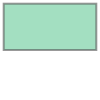

In [3]:
total_collector_geometry = geometry.box(-1, -0.5, 1, 0.5)
total_collector_geometry

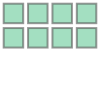

In [4]:
active_collector_geometry = geometry.MultiPolygon([
    geometry.box(-0.95, -0.45, -0.55, -0.05),
    geometry.box(-0.45, -0.45, -0.05, -0.05),
    geometry.box(0.05, -0.45, 0.45, -0.05),
    geometry.box(0.55, -0.45, 0.95, -0.05),
    geometry.box(-0.95, 0.05, -0.55, 0.45),
    geometry.box(-0.45, 0.05, -0.05, 0.45),
    geometry.box(0.05, 0.05, 0.45, 0.45),
    geometry.box(0.55, 0.05, 0.95, 0.45)])

active_collector_geometry

## Define field layout

The field layout used for this demonstration is a hexagonal field layout located on a sloped ground with a tilt of 5 degrees.

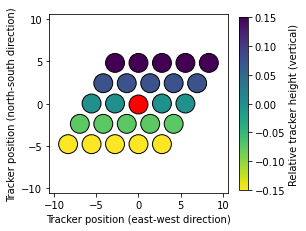

In [5]:
tracker_field = twoaxistracking.TrackerField(
    total_collector_geometry=total_collector_geometry,
    active_collector_geometry=active_collector_geometry,
    neighbor_order=2,  # recommended neighbor order
    gcr=0.3,
    aspect_ratio=3**0.5/2,
    offset=-0.5,
    rotation=90,  # counterclockwise rotation
    slope_azimuth=180,  # degrees east of north
    slope_tilt=5,  # field tilt in degrees
)

_ = tracker_field.plot_field_layout()

## Calculate solar position

The solar position is easily calculated using [pvlib](https://pvlib-python.readthedocs.io/).

In [6]:
location = pvlib.location.Location(latitude=54.97870, longitude=12.2669)

# Generate series of timestamps for one day
timestamps = pd.date_range(start='2021-03-28 05:00', end='2021-03-28 17:45', freq='1min')

# Calculate solar position
solpos = location.get_solarposition(timestamps)

## Define plot function

The following function defines the custom plot, which shows the shading conditions (example below). The main plot (left) shows the unshaded (green) and shaded (red) areas of the reference collector, as well as the projected shadows of the neighboring collectors.

The solar elevation angle and the shaded fraction are plotted continuously on the left.

![example plot of shading conditions](../images/twoaxistracking_example_plot.png "shading example")

In [7]:
def plot_shading_conditions(shading_fractions, active_collector_geometry, unshaded_geometry,
                            shading_geometries, min_tracker_spacing, save_path=None):
    # Create plot
    fig = plt.figure(figsize=(8, 3.5))
    ax0 = plt.subplot(121)
    ax1 = plt.subplot(222)
    ax2 = plt.subplot(224)

    # Create path collections
    active_patches = twoaxistracking.plotting._polygons_to_patch_collection(
        active_collector_geometry, facecolor='red', linewidth=1, alpha=0.5)
    unshaded_patches = twoaxistracking.plotting._polygons_to_patch_collection(
        unshaded_geometry, facecolor='green', linewidth=1)
    shading_patches = twoaxistracking.plotting._polygons_to_patch_collection(
        shading_geometries, facecolor='black', linewidth=0.5, alpha=0.35)

    # Plot path collections
    ax0.add_collection(active_patches, autolim=True)
    ax0.add_collection(shading_patches, autolim=True)
    ax0.add_collection(unshaded_patches, autolim=True)

    # Set limits and ticks for the main plot
    ax0.set_xlim(-min_tracker_spacing, min_tracker_spacing)
    ax0.set_ylim(-min_tracker_spacing, min_tracker_spacing)
    ax0.set_xticks([])
    ax0.set_yticks([])

    # Create legend for the main plot
    green_patch = mpatches.Patch(color='green', label='Unshaded area')
    black_patch = mpatches.Patch(color='black', alpha=0.35, label='Shading areas')
    red_patch = mpatches.Patch(color='red', label='Shaded area')
    ax0.legend(handles=[green_patch, black_patch, red_patch],
               frameon=False, handlelength=1)

    # Plot solar elevation
    ax1.plot(solpos.index[:len(shading_fractions)], solpos['elevation'].iloc[:len(shading_fractions)])
    ax1.set_xlim(solpos.index[0], solpos.index[-1])
    ax1.set_ylim(0, 45)
    ax1.set_yticks([0, 15, 30, 45])
    ax1.set_ylabel('Solar elevation')

    # Plot shading fraction
    ax2.plot(solpos.index[:len(shading_fractions)], shading_fractions)
    ax2.set_xlim(solpos.index[0], solpos.index[-1])
    ax2.set_ylim(-0.01, 1.01)
    ax2.set_ylabel('Shaded fraction')
    ax2.set_yticks([0, 0.25, 0.50, 0.75, 1.00])

    # Format xticks
    xticks = pd.date_range(start=solpos.index[0].round('1h'),
                           end=solpos.index[-1], freq='3h')
    ax1.set_xticks(xticks)
    ax2.set_xticks(xticks)
    ax1.set_xticklabels([])  # Only have x-tick labels on bottom plot
    ax2.set_xticklabels(xticks.strftime('%H:%M'))

    # Make figure pretty
    fig.align_ylabels()
    fig.tight_layout(w_pad=2.0)

    # Save figure
    if save_path is None:
        plt.show()
    else:
        fig.savefig(save_path, bbox_inches='tight')
        plt.close()

## Generate one plot for each timestep

In order to create an animation, the individual plots first need to be generated. In the code block below, a unique plot for each timestep (solar position) is generated and saved.

In [8]:
shading_fractions = []

for index, row in solpos.iterrows():
    # Calculate shading fraction and shading geometries
    sf, geometries = twoaxistracking.shaded_fraction(
        row['elevation'],
        row['azimuth'],
        tracker_field.total_collector_geometry,
        tracker_field.active_collector_geometry,
        tracker_field.min_tracker_spacing,
        tracker_field.tracker_distance,
        tracker_field.relative_azimuth,
        tracker_field.relative_slope,
        tracker_field.slope_azimuth,
        tracker_field.slope_tilt,
        max_shading_elevation=90,
        plot=False,
        return_geometries=True)

    # Append shading fraction to list
    shading_fractions.append(sf)

    # Generate and save plots
    _ = plot_shading_conditions(
        shading_fractions=shading_fractions,
        active_collector_geometry=tracker_field.active_collector_geometry,
        unshaded_geometry=geometries['unshaded_geometry'],
        shading_geometries=geometries['shading_geometries'],
        min_tracker_spacing=tracker_field.min_tracker_spacing,
        save_path=f"GIF/{index.isoformat().replace(':','-')}.png")

## Create GIF

The last step is to combine all the individual images into a GIF.

The file size of the GIF can be reduced significantly with hardly any reduction in quality. For example, the generated GIF was reduced from +6 MB to roughly 800 kB using http://gifgifs.com/optimizer/.

In [9]:
# Get filenames of all images
filenames = glob.glob("GIF/*")

# Load all images and append to list
images = [imageio.imread(filename) for filename in filenames]

# Save GIF
imageio.mimsave('shading_demonstration.gif', images, duration=0.02)

C:\Users\arajen\Anaconda3\envs\twoaxistracking\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  """
